In [1]:
import pandas as pd
import numpy as np
import pickle
import re
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
sns.set
%matplotlib inline

In [2]:
import spacy
import nltk
from nltk import word_tokenize,sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.gensim
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label,ColumnDataSource,Legend, LegendItem
from bokeh.io import output_notebook
from gensim.models import CoherenceModel
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Userpc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Userpc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<h4>Load tasks table</h4>

In [3]:
with open('tasks_eda.pkl', 'rb') as input_file:
    tasks = pickle.load(input_file)   
tasks.columns

Index(['repo_count', 'task_name', 'method_description', 'mod_keys_found',
       'mod_values_found', 'key_module_text', 'value_module_text',
       'mod_keys_found_string', 'found_used_parameters', 'has_params',
       'third_ast', 'third_tokens', 'token_task_names', 'descr_one_string',
       'consistent', 'task_com', 'task_complete'],
      dtype='object')

In [4]:
tasks = tasks[tasks['consistent'] == True]
tasks.shape

(10396, 17)

In [5]:
def remove_first(lst):
    
    lst.remove(lst[0])
    return lst

In [6]:
tasks['token_task_names'] = tasks['token_task_names'].apply(lambda x: remove_first(x))

In [7]:
tasks['token_task_names_one_string'] = tasks['token_task_names'].apply(lambda x: ' '.join(x))

In [8]:
tasks['token_task_names_one_string']

0                                    restart datadog-agent
1                    Create Datadog agent config directory
2             Create main Datadog agent configuration file
3        Ensure configuration directories are present f...
4        Create a configuration file for each Datadog c...
                               ...                        
10391    RedHat 6 | Enabling Red Hat Software Collectio...
10392     Set Distribution CIS filename for RHEL5/CentOS-5
10393     Set Distribution CIS filename for RHEL6/CentOS-6
10394     Set Distribution CIS filename for RHEL7/CentOS-7
10395    Set Distribution CIS filename for RHEL7/CentOS...
Name: token_task_names_one_string, Length: 10396, dtype: object

In [9]:
# tasks_names = tasks['task_name']

In [10]:
corpus_tasks = [token for token in tasks['token_task_names']]

In [11]:
lowercase_tasks = [[token.lower() for token in doc] for doc in corpus_tasks]

In [12]:
alphas_tasks = [[token for token in doc if token.isalpha()] for doc in lowercase_tasks]

In [168]:
stop_words = stopwords.words('english')
stop_words.extend(['for','the','flight','elasticsearch', 'docker','ca'])

In [169]:
tasks_no_stop = [[token for token in doc if token not in stop_words] for doc in alphas_tasks]
# tasks_no_stop

In [170]:
tasks_clean_no_stem = [ ' '.join(doc) for doc in tasks_no_stop]

In [171]:
stemmer = PorterStemmer()
stemmed_tasks = [[stemmer.stem(token) for token in doc] for doc in tasks_no_stop]

In [172]:
tasks_clean_str = [ ' '.join(doc) for doc in stemmed_tasks]

<h4>Number of words</h4>

In [173]:
nb_words = [len(tokens) for tokens in alphas_tasks]
type(nb_words)

list

<h4>Number of unique words</h4>

In [174]:
alphas_unique = [set(doc) for doc in alphas_tasks]
nb_words_unique = [len(doc) for doc in alphas_unique]

<h4>Number of characters</h4>

In [175]:
tasks_str = [' '.join(doc) for doc in lowercase_tasks]

In [176]:
nb_characters = [len(doc) for doc in tasks_str]

<h4>Number of stopwords</h4>

In [177]:
tasks_stopwords = [[token for token in doc if token in stop_words] for doc in alphas_tasks]

In [178]:
nb_stopwords  = [len(doc) for doc in tasks_stopwords]

<h4>Number of punctuations</h4>

In [179]:
non_alphas = [[token for token in doc if token.isalpha() == False] for doc in lowercase_tasks]

In [180]:
nb_punctuation = [len(doc) for doc in non_alphas]

<h4>Number of title case words</h4>

In [181]:
tasks_title = [[token for token in doc if token.istitle() == True] for doc in corpus_tasks]

In [182]:
nb_title = [len(doc) for doc in tasks_title]

<h4>New DataFrame</h4>

In [183]:
df_clean = pd.DataFrame(data={'text_clean':tasks_clean_str})
df_clean

,text_clean
0,restart
1,creat datadog agent config directori
2,creat main datadog agent configur file
3,ensur configur directori present datadog check
4,creat configur file datadog check
...,...
10391,redhat enabl red hat softwar collect rhscl
10392,set distribut ci filenam
10393,set distribut ci filenam
10394,set distribut ci filenam


In [184]:
nb_words = pd.Series(nb_words)
nb_words_unique = pd.Series(nb_words_unique)
nb_characters = pd.Series(nb_characters)
nb_stopwords = pd.Series(nb_stopwords)
nb_punctuation = pd.Series(nb_punctuation)
nb_title = pd.Series(nb_title)

In [185]:
df_show = pd.concat([df_clean,nb_words,nb_words_unique,nb_characters,nb_stopwords,nb_punctuation,nb_title],
                    axis=1).rename(columns={
    0:'Number of words',1:'Number of unique words',2:'Number of characters',3:'Number of stopwords',4:'Number of punctuations',
    5:'Number of titlecase words'
})
df_show

,text_clean,Number of words,Number of unique words,Number of characters,Number of stopwords,Number of punctuations,Number of titlecase words
0,restart,1,1,21,0,1,0
1,creat datadog agent config directori,5,5,37,0,0,2
2,creat main datadog agent configur file,6,6,44,0,0,2
3,ensur configur directori present datadog check,9,9,67,3,0,2
4,creat configur file datadog check,8,8,50,3,0,2
...,...,...,...,...,...,...,...
10391,redhat enabl red hat softwar collect rhscl,7,7,58,0,4,5
10392,set distribut ci filenam,5,5,48,1,1,2
10393,set distribut ci filenam,5,5,48,1,1,2
10394,set distribut ci filenam,5,5,48,1,1,2


In [186]:
df_feat = df_show.drop(['text_clean'],axis=1)
df_feat.head()

,Number of words,Number of unique words,Number of characters,Number of stopwords,Number of punctuations,Number of titlecase words
0,1,1,21,0,1,0
1,5,5,37,0,0,2
2,6,6,44,0,0,2
3,9,9,67,3,0,2
4,8,8,50,3,0,2


In [187]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10396 entries, 0 to 10395
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Number of words            10396 non-null  int64
 1   Number of unique words     10396 non-null  int64
 2   Number of characters       10396 non-null  int64
 3   Number of stopwords        10396 non-null  int64
 4   Number of punctuations     10396 non-null  int64
 5   Number of titlecase words  10396 non-null  int64
dtypes: int64(6)
memory usage: 487.4 KB


In [188]:
sth = []
aa = pd.Series(sth)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


<h4>Length of sentence</h4>

In [189]:
nb_words_tasks_nostop  = [len(tokens) for tokens in tasks_no_stop]

<h4>Average number of words per task</h4>

In [190]:
avg_nostop = np.mean(nb_words_tasks_nostop)
avg_nostop

3.4900923432089264

In [191]:
nb_words_tasks_stop  = [len(tokens) for tokens in lowercase_tasks]
avg_stop = np.mean(nb_words_tasks_stop)
avg_stop

5.0957098884186225

In [192]:
np.median(nb_words_tasks_nostop)

3.0

In [193]:
np.median(nb_words_tasks_stop)

4.0

In [194]:
nb_words_tasks_stop = pd.Series(nb_words_tasks_stop)
nb_words_tasks_nostop = pd.Series(nb_words_tasks_nostop)

In [195]:
df_task_names = pd.DataFrame(tasks['token_task_names_one_string'])

In [196]:
df_task_names.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10396 entries, 0 to 10395
Data columns (total 1 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   token_task_names_one_string  10396 non-null  object
dtypes: object(1)
memory usage: 162.4+ KB


In [197]:
df_name_tasks = pd.concat([df_task_names.reset_index(),nb_words_tasks_nostop,nb_words_tasks_stop],axis=1).set_index('index').rename(columns={
    0: "nb_words_no_stop", 1: 'nb_words_stop'})
df_name_tasks.head()

,token_task_names_one_string,nb_words_no_stop,nb_words_stop
index,,,
0,restart datadog-agent,1,2
1,Create Datadog agent config directory,5,5
2,Create main Datadog agent configuration file,6,6
3,Ensure configuration directories are present f...,6,9
4,Create a configuration file for each Datadog c...,5,8


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


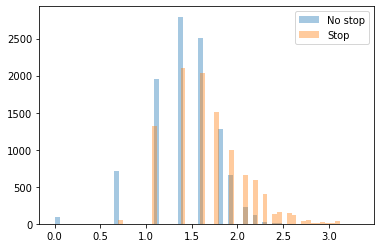

In [198]:
sns.distplot(np.log1p(nb_words_tasks_nostop), kde=False, label="No stop")
sns.distplot(np.log1p(nb_words_tasks_stop), kde=False, label="Stop")
plt.legend();

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


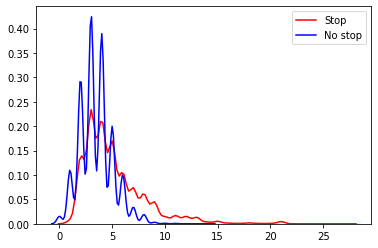

In [199]:
sns.distplot(nb_words_tasks_stop, hist=False, color='red', label='Stop')
sns.distplot(nb_words_tasks_nostop, hist=False, color='blue', label='No stop')
plt.legend();

<h4>Counting the ten most common words in the tasks</h4>

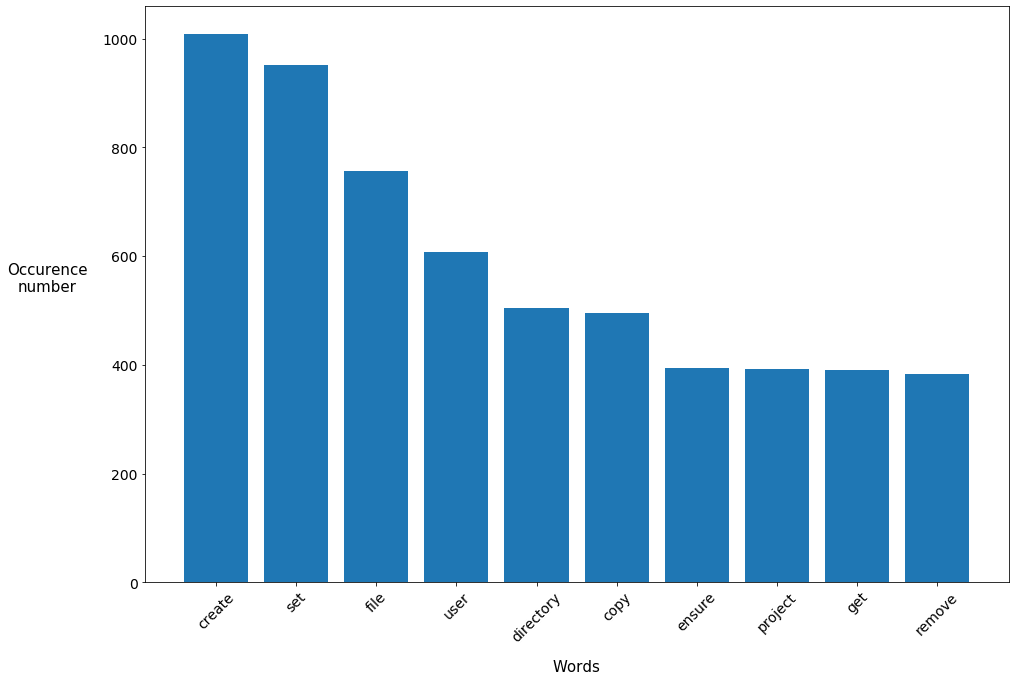

In [200]:
counter = defaultdict(int)
for doc in tasks_no_stop:
    for token in doc:
        counter[token] += 1

from collections import Counter

c = Counter(counter)

commons = c.most_common(10)
x = [x[0] for x in commons]
y = [x[1] for x in commons]
fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0,0,1,1])
ax.grid(False)
plt.bar(x,y)
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=15,labelpad=15)
plt.ylabel('Occurence\nnumber', fontsize=15,rotation=0,labelpad=55)
# plt.savefig('top10_words.jpg',bbox_inches = 'tight')
plt.show()

<h4>Topic modelling with LDA</h4>

In [201]:
dictionary = corpora.Dictionary(tasks_no_stop)

In [202]:
corpus_1_tasks = [dictionary.doc2bow(token) for token in tasks_no_stop]

In [203]:
%%time
lda_model = LdaModel(corpus = corpus_1_tasks, id2word=dictionary, num_topics=6,random_state=45)

Wall time: 3.71 s


In [204]:
print('Perplexity: ', lda_model.log_perplexity(corpus_1_tasks))  

Perplexity:  -6.988860222356582


In [205]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=tasks_no_stop, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

In [206]:
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.6109055074460227


In [207]:
pprint(lda_model.print_topics())

[(0,
  '0.054*"facts" + 0.044*"testing" + 0.041*"files" + 0.026*"complete" + '
  '0.026*"configure" + 0.025*"tasks" + 0.024*"deploy" + 0.020*"template" + '
  '0.017*"ssh" + 0.016*"key"'),
 (1,
  '0.063*"check" + 0.049*"populate" + 0.028*"enabled" + 0.028*"node" + '
  '0.027*"get" + 0.026*"service" + 0.021*"services" + 0.019*"ensure" + '
  '0.018*"version" + 0.016*"master"'),
 (2,
  '0.046*"user" + 0.046*"run" + 0.031*"overcloud" + 0.031*"host" + '
  '0.028*"install" + 0.026*"create" + 0.024*"config" + 0.021*"fail" + '
  '0.020*"role" + 0.019*"output"'),
 (3,
  '0.147*"set" + 0.083*"create" + 0.056*"directory" + 0.041*"ensure" + '
  '0.035*"fact" + 0.023*"exists" + 0.021*"lack" + 0.017*"certificates" + '
  '0.016*"file" + 0.012*"hosts"'),
 (4,
  '0.039*"remove" + 0.034*"get" + 0.029*"list" + 0.025*"legacy" + 0.024*"nova" '
  '+ 0.024*"verify" + 0.023*"undercloud" + 0.022*"copy" + 0.019*"add" + '
  '0.017*"failed"'),
 (5,
  '0.040*"warn" + 0.035*"file" + 0.033*"test" + 0.033*"fail" + 0.0

In [208]:
x=lda_model.show_topics(num_topics=6, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for topic,words in topics_words:
    print(" ".join(words))

facts testing files complete configure tasks deploy template ssh key
check populate enabled node get service services ensure version master
user run overcloud host install create config fail role output
set create directory ensure fact exists lack certificates file hosts
remove get list legacy nova verify undercloud copy add failed
warn file test fail restart script copy generate delete available


In [209]:
%%time
lda_model_1 = LdaModel(corpus=corpus_1_tasks, id2word=dictionary, num_topics=6, random_state=42, iterations=100,alpha='asymmetric',eta='symmetric')

Wall time: 3.85 s


In [210]:
print('Perplexity: ', lda_model_1.log_perplexity(corpus_1_tasks))  

Perplexity:  -6.989738595300217


In [221]:
coherence_model_lda_1 = CoherenceModel(model=lda_model_1, texts=tasks_no_stop, dictionary=dictionary, coherence='c_v')
coherence_lda_1 = coherence_model_lda.get_coherence()

In [222]:
print('Coherence Score: ', coherence_lda_1)

Coherence Score:  0.6109055074460227


In [213]:
pprint(lda_model_1.print_topics())

[(0,
  '0.074*"ensure" + 0.053*"directory" + 0.038*"config" + 0.021*"restart" + '
  '0.020*"files" + 0.020*"create" + 0.019*"service" + 0.016*"image" + '
  '0.016*"cli" + 0.015*"enable"'),
 (1,
  '0.049*"check" + 0.034*"enabled" + 0.032*"get" + 0.031*"key" + '
  '0.030*"configure" + 0.029*"generate" + 0.029*"set" + 0.023*"delete" + '
  '0.018*"exists" + 0.015*"environment"'),
 (2,
  '0.044*"get" + 0.043*"populate" + 0.028*"install" + 0.027*"fail" + '
  '0.021*"certificates" + 0.019*"service" + 0.018*"legacy" + 0.017*"create" + '
  '0.017*"copy" + 0.017*"deploy"'),
 (3,
  '0.040*"testing" + 0.037*"fail" + 0.033*"run" + 0.032*"test" + '
  '0.025*"directory" + 0.025*"overcloud" + 0.022*"nova" + 0.022*"create" + '
  '0.019*"add" + 0.018*"undercloud"'),
 (4,
  '0.128*"set" + 0.038*"fact" + 0.027*"file" + 0.027*"lack" + 0.024*"copy" + '
  '0.021*"copying" + 0.019*"verify" + 0.017*"host" + 0.017*"services" + '
  '0.017*"remove"'),
 (5,
  '0.063*"create" + 0.053*"facts" + 0.040*"warn" + 0.025*

In [214]:
x=lda_model_1.show_topics(num_topics=6, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for topic,words in topics_words:
    print(" ".join(words))

ensure directory config restart files create service image cli enable
check enabled get key configure generate set delete exists environment
get populate install fail certificates service legacy create copy deploy
testing fail run test directory overcloud nova create add undercloud
set fact file lack copy copying verify host services remove
create facts warn node user set complete tasks file hosts


In [215]:
pyLDAvis.enable_notebook()

In [216]:
pyLDAvis.gensim.prepare(lda_model, corpus_1_tasks, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.013436 -0.269314       1        1  20.748407
0     -0.315134  0.030495       2        1  17.452597
5     -0.037429  0.098504       3        1  16.342667
4      0.106096  0.192020       4        1  15.711964
2      0.146666  0.016727       5        1  15.668121
1      0.086365 -0.068432       6        1  14.076251, topic_info=           Term         Freq        Total Category  logprob  loglift
20          set  1178.000000  1178.000000  Default  30.0000  30.0000
3        create   777.000000   777.000000  Default  29.0000  29.0000
793       facts   343.000000   343.000000  Default  28.0000  28.0000
5     directory   440.000000   440.000000  Default  27.0000  27.0000
9         check   434.000000   434.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
11       ensure    99.319092   453.395905   Topic6  -3.9401   0.4423
2448      hiera    42.396400   105.151505   Topic6  -4.7914   1.0523
39         fail    70.929680   546.758606   Topic6  -4.2767  -0.0816
89      copying    44.484612   195.980408   Topic6  -4.7433   0.4778
20          set    44.821037  1178.507080   Topic6  -4.7357  -1.3086

[334 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
582       1  0.972855     access
527       3  0.938196    account
223       1  0.012655        add
223       2  0.075932        add
223       3  0.006328        add
...     ...       ...        ...
2149      3  0.010894  workspace
2149      4  0.359515  workspace
2149      6  0.010894  workspace
178       3  0.015474      write
178       5  0.974882      write

[622 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 6, 5, 3, 2])

In [217]:
pyLDAvis.gensim.prepare(lda_model_1, corpus_1_tasks, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.046268  0.088056       1        1  18.722729
0      0.033220 -0.199538       2        1  17.319324
5      0.060414  0.210569       3        1  16.922794
2     -0.085315 -0.134150       4        1  15.996225
1      0.213668 -0.025328       5        1  15.562259
3     -0.268256  0.060391       6        1  15.476671, topic_info=            Term         Freq        Total Category  logprob  loglift
20           set  1244.000000  1244.000000  Default  30.0000  30.0000
11        ensure   560.000000   560.000000  Default  29.0000  29.0000
793        facts   324.000000   324.000000  Default  28.0000  28.0000
5      directory   496.000000   496.000000  Default  27.0000  27.0000
979     populate   250.000000   250.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2438  developers    53.702976   142.818649   Topic6  -4.6498   0.8877
2437    molecule    53.708080   148.383392   Topic6  -4.6497   0.8496
276         list    55.243439   176.846985   Topic6  -4.6215   0.7023
2448       hiera    45.572704   101.222946   Topic6  -4.8140   1.0678
286          get    39.171783   481.259247   Topic6  -4.9653  -0.6426

[352 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
582       2  0.987091   access
527       5  0.982985  account
160       2  0.942156   actual
223       1  0.063941      add
223       2  0.021314      add
...     ...       ...      ...
178       2  0.017528    write
178       3  0.806289    write
178       4  0.157752    write
178       6  0.017528    write
1913      1  0.958305     zuul

[634 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 1, 6, 3, 2, 4])

In [63]:
weight_topic = lda_model_1.top_topics(corpus=corpus_1_tasks, dictionary=dictionary, topn=30)

<h4>Top unigrams before removing stop words</h4>

In [64]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(tasks['token_task_names_one_string'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['token_task_names_one_string' , 'count'])

for 1221
the 1121
create 1010
set 952
to 930
file 756
user 617
if 580
check 568
directory 505
copy 496
config 468
project 404
ensure 395
get 392
is 389
service 385
remove 383
and 381
files 361


<h4>Top unigrams after removing stop words</h4>

In [65]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(tasks['token_task_names_one_string'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['token_task_names_one_string' , 'count'])

create 1010
set 952
file 756
user 617
check 568
directory 505
copy 496
config 468
project 404
ensure 395
service 385
remove 383
files 361
generate 338
restart 313
copying 304
complete 289
tasks 269
exists 250
run 249


<h4>Top bigrams before removing stop words</h4>

In [66]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(tasks['token_task_names_one_string'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['token_task_names_one_string' , 'count'])

copying over 265
tasks complete 246
flight check 183
check if 169
remove user 164
post_workload tasks 138
fail if 133
set fact 123
fact for 120
wait for 112
ensure legacy 108
legacy workspace 108
workspace directory 108
user quota 105
create the 99
make sure 96
hosts file 94
files for 92
check for 92
step 00xxxxx 89


<h4>Top bigrams after removing stop words</h4>

In [67]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(tasks['token_task_names_one_string'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['token_task_names_one_string' , 'count'])

tasks complete 246
flight check 183
remove user 164
post_workload tasks 138
set fact 123
ensure legacy 108
legacy workspace 108
workspace directory 108
user quota 105
hosts file 96
make sure 96
step 00xxxxx 89
ansible hosts 88
directory exists 86
directories exist 82
ensuring config 81
create user 80
generate ssh 77
config directories 77
policy file 76


<h4>Top trigrams before removing stop words</h4>

In [68]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(tasks['token_task_names_one_string'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['token_task_names_one_string' , 'count'])

post_workload tasks complete 136
set fact for 108
ensure legacy workspace 108
legacy workspace directory 108
ansible hosts file 81
config directories exist 76
ensuring config directories 73
config json files 73
copying over config 70
over config json 70
presoftware flight check 69
files for services 69
json files for 67
software flight check 64
remove user quota 61
user quota oc 61
quota oc delete 61
oc delete clusterresourcequota 61
configure all hosts 60
all hosts with 60


In [69]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(tasks['token_task_names_one_string'], 20)
for word, freq in common_words:
    print(word, freq)
df6 = pd.DataFrame(common_words, columns = ['token_task_names_one_string' , 'count'])

post_workload tasks complete 136
ensure legacy workspace 108
legacy workspace directory 108
ansible hosts file 81
config directories exist 76
ensuring config directories 73
config json files 73
copying config json 70
presoftware flight check 69
software flight check 64
json files services 64
remove user quota 61
user quota oc 61
quota oc delete 61
oc delete clusterresourcequota 61
configure hosts repositories 60
hosts repositories common 60
repositories common files 60
common files set 60
files set environment 60


<h4>Topic Modeling with LSA</h4>

In [79]:
stop_words2 = stopwords.words('english')
stop_words2.extend(['for','the','flight','copying'])

In [80]:
reindexed_data = tasks_clean_no_stem
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words2, use_idf=True, smooth_idf=True)
# reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)

In [81]:
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

In [82]:
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [83]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [84]:
def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [85]:
top_n_words_lsa = get_top_n_words(, lsa_keys, document_term_matrix, tfidf_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  complete tasks wait workload following
Topic 2:  create project service add script
Topic 3:  set restart fact run fail
Topic 4:  ensure directory exists legacy workspace
Topic 5:  copy file software generate config
Topic 6:  user remove check get files


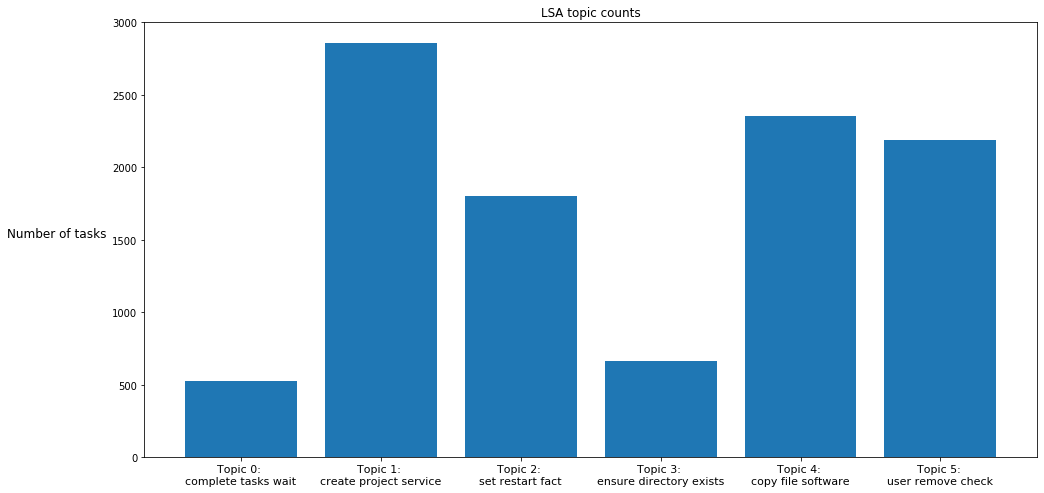

In [86]:
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.grid(False)
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
# ax.set_ylabel('Number of tasks');
ax.set_title('LSA topic counts');
# plt.bar(lsa_categories,lsa_counts)
plt.xticks(fontsize=11,rotation=0)
# plt.yticks(fontsize=14)
# plt.xlabel('Top words per topic', fontsize=15,labelpad=15)
plt.ylabel('Number of tasks',fontsize=12,rotation=0,labelpad=55)
# plt.savefig('lsa_tasks.jpg',bbox_inches = 'tight')
plt.show()

In [77]:
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10396 samples in 0.010s...
[t-SNE] Computed neighbors for 10396 samples in 0.764s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10396
[t-SNE] Computed conditional probabilities for sample 2000 / 10396
[t-SNE] Computed conditional probabilities for sample 3000 / 10396
[t-SNE] Computed conditional probabilities for sample 4000 / 10396
[t-SNE] Computed conditional probabilities for sample 5000 / 10396
[t-SNE] Computed conditional probabilities for sample 6000 / 10396
[t-SNE] Computed conditional probabilities for sample 7000 / 10396
[t-SNE] Computed conditional probabilities for sample 8000 / 10396
[t-SNE] Computed conditional probabilities for sample 9000 / 10396
[t-SNE] Computed conditional probabilities for sample 10000 / 10396
[t-SNE] Computed conditional probabilities for sample 10396 / 10396
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.655609
[t-SNE] KL

In [79]:
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        reviews_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                reviews_in_that_topic.append(two_dim_vectors[i])    
        
        reviews_in_that_topic = np.vstack(reviews_in_that_topic)
        mean_review_in_that_topic = np.mean(reviews_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_review_in_that_topic)
    return mean_topic_vectors

In [80]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [82]:
top_3_words_lsa = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

source = ColumnDataSource(dict(
    x=tsne_lsa_vectors[:,0],
    y=tsne_lsa_vectors[:,1],
    color=colormap,
    label=top_3_words_lsa,
))

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x='x', y='y', color='color',legend_field='label', source = source)
    
show(plot)